# Библиотеки

In [2]:
import pandas as pd
import numpy as np
import gc

# Константы

In [3]:
RAWDATADIR = 'data/raw'
DATADIR = 'data'

## Словарь по целевым постам

In [4]:
kirensk_dict = {
    'name': 'Киренск',
    'id': 3019,
    'meteo_st': [30028, 30219, 30328, 30337, 30433, 30230],
    'gydro_st': [3087, 3021],
    'id_influencer': []
}

vitim_dict = {
    'name': 'Витим',
    'id': 3027,
    'meteo_st': [24713, 24726, 24817, 30356, 30471, 30372, 30069, 30253, 30252, 24923],
    'gydro_st': [3106, 3555, 3024, 3554, 3028, 3029, 3030, 3031, 3032],
    'id_influencer': [3019]
}

peledui_dict = {
    'name': 'Пеледуй',
    'id': 3028,
    'meteo_st': [24713, 24726, 24817, 30356, 30471, 30372, 30069, 30253, 30252, 24923],
    'gydro_st': [3106, 3555, 3024, 3554, 3027, 3029, 3030, 3031, 3032],
    'id_influencer': [3019, 3027]
}

krestovskiy_dict = {
    'name': 'Крестовский Лесоучасток',
    'id': 3029,
    'meteo_st': [24713, 24726, 24817, 30356, 30471, 30372, 30069, 30253, 30252, 24923],
    'gydro_st': [3106, 3555, 3024, 3554, 3027, 3028, 3030, 3031, 3032],
    'id_influencer': [3019, 3027, 3028]
}

lensk_dict = {
    'name': 'Ленск',
    'id': 3030,
    'meteo_st': [24713, 24726, 24817, 30356, 30471, 30372, 30069, 30253, 30252, 24923],
    'gydro_st': [3106, 3555, 3024, 3554, 3027, 3028, 3029, 3031, 3032],
    'id_influencer': [3019, 3027, 3028, 3029]
}

olekminsk_dict = {
    'name': 'Олекминск',
    'id': 3035,
    'meteo_st': [24538,24738,24641,24933,30089,30385,30493,30393,31102,31004,24951,24944],
    'gydro_st': [3180,3169,3036,3037,3038],
    'id_influencer': [3019, 3027, 3028, 3029, 3030]
}

pokrovsk_dict = {
    'name': 'Покровск',
    'id': 3041,
    'meteo_st': [31137,31026,24967,24966,24641,24643,24661,24671,24763],
    'gydro_st': [3042,3045,3047,3048],
    'id_influencer': [3019, 3027, 3028, 3029, 3030, 3035]
}

yakutsk_dict = {
    'name': 'Якутск',
    'id': 3045,
    'meteo_st': [31137,31026,24967,24966,24641,24643,24661,24671,24763],
    'gydro_st': [3042,3041,3047,3048],
    'id_influencer': [3019, 3027, 3028, 3029, 3030, 3035, 3041]
}

batamay_dict = {
    'name': 'Батамай',
    'id': 3230,
    'meteo_st': [31137,31026,24967,24966,24641,24643,24661,24671,24763],
    'gydro_st': [3229,3050],
    'id_influencer': [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045]
}

sangar_dict = {
    'name': 'Сангар',
    'id': 3050,
    'meteo_st': [31137,31026,24967,24966,24641,24643,24661,24671,24763],
    'gydro_st': [3229,3230],
    'id_influencer': [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045, ]
}

# Методы

## df_preprocessing

In [78]:
def df_preprocessing(df, station_id, verbose=False):
    """
    Предобработка данных по указанной гидростанции станции
    """
    tr_data = df[(df.station_id == station_id)].copy()

    # если замер льда не делали, то пусть 0 будет такой категорией
    tr_data['place'].fillna(0, inplace=True)
    # water_code и place должны быть категориальными
    tr_data['water_code'] = tr_data['water_code'].astype('str')
    tr_data['place'] = tr_data['place'].astype('int8')
    
    # проверка признаков на наличие пропусков
    na_features = []
    if verbose: print('Пропуски:')
    for col in tr_data.columns:
        cnt = tr_data[col].isna().sum()
        if cnt > 0:
            if verbose: print(col, ':', cnt)
            na_features.append(col)
    if verbose: print()
    if len(na_features) > 0:
        # находим значения для заполнения праметров с пропусками, учитывая специфику каждого месяца
        na_features_dict = dict()
        for f in na_features:
            na_features_dict[f] = dict()
        for feature in na_features:
            for i in range(1, 13):
                val = tr_data.loc[tr_data.month == i, feature].median()
                # признак если среднего расхода воды не знаем или не замеряется на посту
                if (val is np.nan)&(feature == 'discharge'):
                    na_features_dict[feature][i] = -1
                elif val is np.nan:
                    na_features_dict[feature][i] = 0.0
                else:
                    na_features_dict[feature][i] = val
        # заполняем пропуски
        for col in na_features:
            for i in range(1,13):
                tr_data.loc[(tr_data.month == i)&(tr_data[col].isna()), col] = na_features_dict[col][i]
            
    return tr_data

## mute_untrastable

In [79]:
def mute_untrastable(df, feature):
    """
    Замена NaN'ами неподтверждённых или опровергнутых данных
    feature - фича с суфиксом _qual
    """
    df.loc[df[feature] > 2, feature] = np.nan
    
    return df

## meteo_data_processing

In [77]:
def meteo_data_processing(meteo_1day, station_id, verbose=False):
    """
    Предобработка метеоданных
    meteo_1day - dataframe с метеоданными, аггрегированные за 1 день
    """
    
    df = meteo_1day[(meteo_1day.station_id == station_id)].copy()
    
    # проверка признаков на наличие пропусков
    na_features = []
    if verbose: print('Пропуски:')
    for col in df.columns:
        cnt = df[col].isna().sum()
        if cnt > 0:
            if verbose: print(col, ':', cnt)
            na_features.append(col)
            
    if len(na_features) > 0:
        # находим значения для заполнения праметров с пропусками, учитывая специфику каждого месяца
        na_features_dict = dict()
        for f in na_features:
            na_features_dict[f] = dict()
        for feature in na_features:
            for i in range(1, 13):
                val = df.loc[df.month_local == i, feature].median()
                if (val is np.nan):
                    na_features_dict[feature][i] = -777
                else:
                    na_features_dict[feature][i] = val
                        
        # заполняем пропуски
        for col in na_features:
            for i in range(1,13):
                df.loc[(df.month_local == i)&(df[col].isna()), col] = na_features_dict[col][i]
            
    return df

# Данные

In [144]:
train_df = pd.read_csv(f'{RAWDATADIR}/track_2_package/train.csv', parse_dates=['date'])

# удаляем наблюдения за 1985-01-01, т.к. изменение уровня воды NaN из-за отсуютсвтия более ранних исторических данных
train_df.drop(train_df[train_df.date == pd.to_datetime('1985-01-01', format='%Y-%m-%d')].index, inplace=True)

### Киренск

In [128]:
tr_data = train_df[(train_df.station_id == kirensk_dict['id'])].copy()

# если замер льда не делали, то пусть 0 будет такой категорией
tr_data['place'].fillna(0, inplace=True)
# water_code и place должны быть категориальными
tr_data['water_code'] = tr_data['water_code'].astype('str')
tr_data['place'] = tr_data['place'].astype('int8')

tr_data.head()

,station_id,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place,discharge,year,month,day,delta_stage_max
0,3019,1985-01-01,-23.0,-23.0,-23.0,NaN,16,NaN,NaN,0,NaN,1985,1,1,NaN
1,3019,1985-01-02,-23.0,-23.0,-23.0,NaN,16,NaN,NaN,0,NaN,1985,1,2,0.0
2,3019,1985-01-03,-23.0,-23.0,-23.0,NaN,16,NaN,NaN,0,NaN,1985,1,3,0.0
3,3019,1985-01-04,-24.0,-24.0,-24.0,NaN,16,NaN,NaN,0,NaN,1985,1,4,-1.0
4,3019,1985-01-05,-24.0,-24.0,-24.0,NaN,16,53.0,29.0,1,NaN,1985,1,5,0.0


In [130]:
# проверка признаков на наличие пропусков
na_features = []
for col in tr_data.columns:
    cnt = tr_data[col].isna().sum()
    if cnt > 0:
        print(col, cnt)
        na_features.append(col)

temp 5372
ice_thickness 10945
snow_height 10968
discharge 11603


In [131]:
na_features

['temp', 'ice_thickness', 'snow_height', 'discharge']

In [132]:
# находим значения для заполнения праметров с пропусками, учитывая специфику каждого месяца

na_features_dict = dict()
for f in na_features:
    na_features_dict[f] = dict()

for feature in na_features:
    for i in range(1, 13):
#         if feature == 'place':
#             na_features_dict[feature][i] = tr_data.loc[tr_data.month == i, feature].mode().values[0]
#         else:
            val = tr_data.loc[tr_data.month == i, feature].mean()
            if (val is np.nan)&(feature == 'discharge'):
                na_features_dict[feature][i] = -1  # признак если среднего расхода воды не знаем или не замеряется на посту
            elif val is np.nan:
                na_features_dict[feature][i] = 0.0
            else:
                na_features_dict[feature][i] = val

na_features_dict

{'temp': {1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.09090909090909091,
  5: 4.593290322580645,
  6: 16.093793103448277,
  7: 20.633577712609974,
  8: 18.358797653958945,
  9: 10.244141414141415,
  10: 2.1803519061583576,
  11: 0.025,
  12: 0.0},
 'ice_thickness': {1: 53.78861788617886,
  2: 62.458333333333336,
  3: 65.61538461538461,
  4: 59.13414634146341,
  5: 41.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 10.0,
  11: 21.8125,
  12: 39.77777777777778},
 'snow_height': {1: 31.6260162601626,
  2: 36.94117647058823,
  3: 33.034188034188034,
  4: 14.603174603174603,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 5.5,
  11: 10.648936170212766,
  12: 24.384615384615383},
 'discharge': {1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1}}

In [133]:
# заполняем пропуски
for col in na_features:
    for i in range(1,13):
#         tr_data.loc[tr_data.month == i, col].fillna(value=na_features_dict[col][i], inplace=True)  # не работает...
        tr_data.loc[(tr_data.month == i)&(tr_data[col].isna()), col] = na_features_dict[col][i]
display(tr_data.head())
tr_data.info()

,station_id,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place,discharge,year,month,day,delta_stage_max
1,3019,1985-01-02,-23.0,-23.0,-23.0,0.0,16,53.788618,31.626016,0,-1.0,1985,1,2,0.0
2,3019,1985-01-03,-23.0,-23.0,-23.0,0.0,16,53.788618,31.626016,0,-1.0,1985,1,3,0.0
3,3019,1985-01-04,-24.0,-24.0,-24.0,0.0,16,53.788618,31.626016,0,-1.0,1985,1,4,-1.0
4,3019,1985-01-05,-24.0,-24.0,-24.0,0.0,16,53.000000,29.000000,1,-1.0,1985,1,5,0.0
5,3019,1985-01-06,-24.0,-24.0,-24.0,0.0,16,53.788618,31.626016,0,-1.0,1985,1,6,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11603 entries, 1 to 11603
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   station_id       11603 non-null  int64         
 1   date             11603 non-null  datetime64[ns]
 2   stage_avg        11603 non-null  float64       
 3   stage_min        11603 non-null  float64       
 4   stage_max        11603 non-null  float64       
 5   temp             11603 non-null  float64       
 6   water_code       11603 non-null  object        
 7   ice_thickness    11603 non-null  float64       
 8   snow_height      11603 non-null  float64       
 9   place            11603 non-null  int8          
 10  discharge        11603 non-null  float64       
 11  year             11603 non-null  int64         
 12  month            11603 non-null  int64         
 13  day              11603 non-null  int64         
 14  delta_stage_max  11603 non-null  float

### Гидрологические данные

In [176]:
tr_data = df_preprocessing(train_df, kirensk_dict['id'])
tr_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11603 entries, 1 to 11603
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   station_id       11603 non-null  int64         
 1   date             11603 non-null  datetime64[ns]
 2   stage_avg        11603 non-null  float64       
 3   stage_min        11603 non-null  float64       
 4   stage_max        11603 non-null  float64       
 5   temp             11603 non-null  float64       
 6   water_code       11603 non-null  object        
 7   ice_thickness    11603 non-null  float64       
 8   snow_height      11603 non-null  float64       
 9   place            11603 non-null  int8          
 10  discharge        11603 non-null  float64       
 11  year             11603 non-null  int64         
 12  month            11603 non-null  int64         
 13  day              11603 non-null  int64         
 14  delta_stage_max  11603 non-null  floa

In [177]:
# соберём данные со смежных постов, выделенных в словаре по данному целевому посту
mapper = dict()
use_feature = ['date', 'stage_avg', 'stage_min','stage_max', 'temp', 'water_code', 'ice_thickness','snow_height', 
               'place', 'discharge']

for n, st in enumerate(kirensk_dict['gydro_st']):
    if n == 0:
        # данные с поста
        df = df_preprocessing(train_df, st)
        df = df[use_feature]
        for col in [x for x in use_feature if x not in ['date']]:
            mapper[col] = f'{col}_{st}'
        gydro_st = df.rename(columns=mapper)
    else:
        # данные с поста
        df = df_preprocessing(train_df, st)
        df = df[use_feature]
        for col in [x for x in use_feature if x not in ['date']]:
            mapper[col] = f'{col}_{st}'
        df.rename(columns=mapper, inplace=True)
        gydro_st = pd.merge(gydro_st, df, on='date')

gydro_st.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 11603 entries, 0 to 11602
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                11603 non-null  datetime64[ns]
 1   stage_avg_3087      11603 non-null  float64       
 2   stage_min_3087      11603 non-null  float64       
 3   stage_max_3087      11603 non-null  float64       
 4   temp_3087           11603 non-null  float64       
 5   water_code_3087     11603 non-null  object        
 6   ice_thickness_3087  11603 non-null  float64       
 7   snow_height_3087    11603 non-null  float64       
 8   place_3087          11603 non-null  int8          
 9   discharge_3087      11603 non-null  float64       
 10  stage_avg_3021      11603 non-null  float64       
 11  stage_min_3021      11603 non-null  float64       
 12  stage_max_3021      11603 non-null  float64       
 13  temp_3021           11603 non-null  float64 

In [179]:
# сводные данные по целевому посту и его окресных гидропостов
kirensk_df = pd.merge(tr_data, gydro_st, on='date')
kirensk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11603 entries, 0 to 11602
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   station_id          11603 non-null  int64         
 1   date                11603 non-null  datetime64[ns]
 2   stage_avg           11603 non-null  float64       
 3   stage_min           11603 non-null  float64       
 4   stage_max           11603 non-null  float64       
 5   temp                11603 non-null  float64       
 6   water_code          11603 non-null  object        
 7   ice_thickness       11603 non-null  float64       
 8   snow_height         11603 non-null  float64       
 9   place               11603 non-null  int8          
 10  discharge           11603 non-null  float64       
 11  year                11603 non-null  int64         
 12  month               11603 non-null  int64         
 13  day                 11603 non-null  int64     

### Метеорологические данные

In [96]:
# метеоданные
meteo_df = pd.read_csv(f'{RAWDATADIR}/track_2_package/meteo_3hours.csv', parse_dates=['date_local'])

# Замена np.nan'ами неподтверждённых или опровергнутых данных
_qual_cols = list(meteo_df.filter(regex='_qual$').columns)
print(meteo_df.shape)
for col in _qual_cols:
    meteo_df = mute_untrastable(meteo_df, col)
print(meteo_df.shape)

features = pd.Series(_qual_cols)
spl_feat = []
for n, f in enumerate(features):
    spl = features.values[n].split('_')
    spl_feat.append(('_'.join(spl[:len(spl)-1])))
    
use_feature = ['station_id', 'date_local', 'month_local'] + spl_feat

meteo_data = meteo_df[use_feature].copy()
print(meteo_data.shape)

del meteo_df
gc.collect()

(3666552, 94)
(3666552, 94)
(3666552, 39)


28

In [97]:
# аггрегация данных с дискретностью 1 день
meteo_1day = meteo_data.groupby(['station_id', 'date_local']).median()
meteo_1day.reset_index(inplace=True)
print(meteo_1day.shape)

del meteo_data
gc.collect()

(458319, 37)


0

In [104]:
mapper = dict()
use_feature = ['date_local'] + spl_feat

# берём данные по нужным станциям
for n, st in enumerate(kirensk_dict['meteo_st']):
    print(n, st)
    if n == 0:
        df = meteo_data_processing(meteo_1day, st)
        df = df[use_feature]
        print(df.shape)
        for col in spl_feat:
            mapper[col] = f'{col}_{st}'
        meteo_st = df.rename(columns=mapper)
    else:
        df = meteo_data_processing(meteo_1day, st)
        df = df[use_feature]
        print(df.shape)
        for col in spl_feat:
            mapper[col] = f'{col}_{st}'
        df.rename(columns=mapper, inplace=True)
        meteo_st = pd.merge(meteo_st, df, how='outer', on='date_local')
        
meteo_st.shape

0 30028
(12279, 37)
1 30219
(11363, 37)
2 30328
(11834, 37)
3 30337
(12279, 37)
4 30433
(12310, 37)
5 30230
(12279, 37)


(12310, 217)

In [107]:
meteo_st.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12310 entries, 0 to 12309
Data columns (total 217 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   date_local                                  datetime64[ns]
 1   horizontal_visibility_30028                 float64       
 2   cloud_amount_total_30028                    float64       
 3   cloud_amount_low_level_30028                float64       
 4   cloud_form_high_level_30028                 float64       
 5   cloud_form_middle_level_30028               float64       
 6   cloud_form_vertical_develop_30028           float64       
 7   cloud_form_strat_stratocum_30028            float64       
 8   cloud_form_strat_rain_30028                 float64       
 9   cloud_base_altitude_30028                   float64       
 10  cloud_below_station_30028                   float64       
 11  soil_surface_condition_30028                float64  

In [111]:
meteo_st.tail()

,date_local,horizontal_visibility_30028,cloud_amount_total_30028,cloud_amount_low_level_30028,cloud_form_high_level_30028,cloud_form_middle_level_30028,cloud_form_vertical_develop_30028,cloud_form_strat_stratocum_30028,cloud_form_strat_rain_30028,cloud_base_altitude_30028,...,air_temperature_max_before_30230,air_max_temperature_30230,water_vapour_partial_pressure_30230,relative_humidity_30230,vapour_pressure_deficit_30230,dew_point_temperature_30230,pressure_30230,pressure_sea_level_30230,barometric_tendency_characteristic_30230,barometric_tendency_30230
12305,2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12306,2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12307,2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12308,2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12309,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='date_local'>

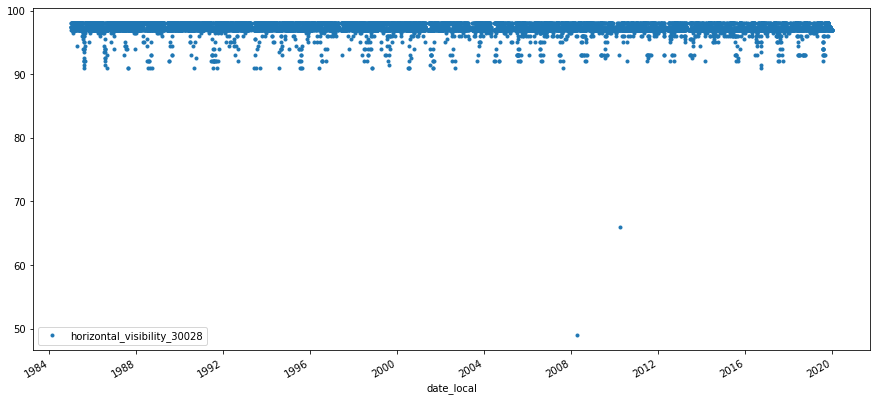

In [113]:
meteo_st.plot('date_local', 'horizontal_visibility_30028', style='.', figsize=(15,7))

In [33]:
kirensk_dict['meteo_st']

[30028, 30219, 30328, 30337, 30433, 30230]

In [46]:
kirensk_dict['meteo_st']

[30028, 30219, 30328, 30337, 30433, 30230]

In [52]:
    verbose = True
    tr_data = meteo_data[meteo_data.station_id == 30328]
    print(tr_data.shape)
    # проверка признаков на наличие пропусков
    na_features = []
    if verbose: print('Пропуски:')
    for col in tr_data.columns:
        cnt = tr_data[col].isna().sum()
        if cnt > 0:
            if verbose: print(col, ':', cnt)
            na_features.append(col)
    print()
    if len(na_features) > 0:
            # находим значения для заполнения праметров с пропусками, учитывая специфику каждого месяца
            na_features_dict = dict()
            for f in na_features:
                na_features_dict[f] = dict()

            for feature in na_features:
                for i in range(1, 13):
                    val = tr_data.loc[tr_data.date_local.dt.month == i, feature].mean()
    
    na_features_dict
    
    # заполняем пропуски
#     for col in na_features:
#         for i in range(1,13):
#             tr_data.loc[(tr_data.month == i)&(tr_data[col].isna()), col] = na_features_dict[col][i]

(9694, 94)
Пропуски:
horizontal_visibility : 9694
cloud_amount_total : 9694
cloud_amount_low_level : 9694
cloud_form_high_level : 9694
cloud_form_middle_level : 9694
cloud_form_vertical_develop : 9694
cloud_form_strat_stratocum : 9694
cloud_form_strat_rain : 9694
cloud_base_altitude : 9694
soil_surface_condition : 9694
weather_before : 9694
weather : 9694
wind_direction : 9694
wind_speed_aver : 9694
wind_speed_max : 9694
precipitation : 9693
soil_surface_temperature : 9694
soil_surface_alco_temperature : 9694
soil_surface_temperature_min_before : 9694
soil_surface_temperature_max_before : 9694
soil_surface_max_temperature : 9694
air_temperature : 9694
air_temperature_wet_bulb : 9694
air_temperature_min_alco_temperature : 9694
air_temperature_min_before : 9694
air_temperature_max_before : 9694
air_max_temperature : 9694
water_vapour_partial_pressure : 9694
relative_humidity : 9694
vapour_pressure_deficit : 9694
dew_point_temperature : 9694
pressure : 9694
pressure_sea_level : 9694
barom

{'horizontal_visibility': {},
 'cloud_amount_total': {},
 'cloud_amount_low_level': {},
 'cloud_form_high_level': {},
 'cloud_form_middle_level': {},
 'cloud_form_vertical_develop': {},
 'cloud_form_strat_stratocum': {},
 'cloud_form_strat_rain': {},
 'cloud_base_altitude': {},
 'soil_surface_condition': {},
 'weather_before': {},
 'weather': {},
 'wind_direction': {},
 'wind_speed_aver': {},
 'wind_speed_max': {},
 'precipitation': {},
 'soil_surface_temperature': {},
 'soil_surface_alco_temperature': {},
 'soil_surface_temperature_min_before': {},
 'soil_surface_temperature_max_before': {},
 'soil_surface_max_temperature': {},
 'air_temperature': {},
 'air_temperature_wet_bulb': {},
 'air_temperature_min_alco_temperature': {},
 'air_temperature_min_before': {},
 'air_temperature_max_before': {},
 'air_max_temperature': {},
 'water_vapour_partial_pressure': {},
 'relative_humidity': {},
 'vapour_pressure_deficit': {},
 'dew_point_temperature': {},
 'pressure': {},
 'pressure_sea_level